## JSON Parsing Sample

**Importing Relevant Libraries**

In [156]:
import requests
import json, csv
from random import randint
import sys
from time import sleep
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain, starmap

In [157]:
#libraries for JSON parsing function
from functools import (partial,
                       singledispatch)
from itertools import chain
from typing import (Dict,
                    List,
                    TypeVar)

**Getting all Factura details**

In [158]:
factura = {
  "@context": "/contexts/Invoice",
  "@id": "/invoices/e0a24894-7fbf-48ae-bfb0-efaae30a6319",
  "@type": "Invoice",
  "id": "e0a24894-7fbf-48ae-bfb0-efaae30a6319",
  "version": 3.3,
  "type": "I",
  "usage": "G03",
  "paymentType": "PUE",
  "paymentMethod": "04",
  "placeOfIssue": "01210",
  "issuer": {
    "rfc": "AOM920820BEA",
    "name": "APPLE OPERATIONS MEXICO S.A. DE C.V."
  },
  "receiver": {
    "rfc": "PEIC211118IS0",
    "name": "Pedro Infante Cruz"
  },
  "currency": "MXN",
  "amount": 53249.8,
  "exchangeRate": 19.8,
  "status": "VIGENTE",
  "pac": "SAT970701NN3",
  "issuedAt": "2019-01-03T21:10:40.000Z",
  "certifiedAt": "2019-01-03T21:10:41.000Z",
  "cancellationStatus": "Cancelable con aceptación",
  "cancellationProcessStatus": "En proceso",
  "canceledAt": "2020-07-13T14:53:41Z",
  "items": [
    {
      "identificationNumber": "Z0V0",
      "productIdentification": "43211503",
      "description": "MBP 15.4 SPACE GRAY",
      "unitAmount": 45905,
      "unitCode": "H87",
      "quantity": 1,
      "discountAmount": 0,
      "taxType": "002",
      "taxRate": 0.16,
      "taxAmount": 7344.8,
      "totalAmount": 45905
    }
  ],
  "xml": True,
  "pdf": True
}

**Function to parse and flatten JSON**

This function is used to parse the JSON data to a python recognised data format, in our case we convert it to a list and then to a Pandas DataFrame

In [159]:
Serializable = TypeVar('Serializable', None, int, bool, float, str, 
                       dict, list, tuple)
Array = List[Serializable]
Object = Dict[str, Serializable]


def flatten(object_: Object,
            *,
            path_separator: str = '.') -> Array[Object]:
    """
    Flattens given JSON object into list of objects with non-nested values.

    >>> flatten({'a': 1})
    [{'a': 1}]
    >>> flatten({'a': [1, 2]})
    [{'a': 1}, {'a': 2}]
    >>> flatten({'a': {'b': None}})
    [{'a.b': None}]
    """
    keys = set(object_)
    result = [dict(object_)]
    while keys:
        key = keys.pop()
        new_result = []
        for index, record in enumerate(result):
            try:
                value = record[key]
            except KeyError:
                new_result.append(record)
            else:
                if isinstance(value, dict):
                    del record[key]
                    new_value = flatten_nested_objects(
                            value,
                            prefix=key + path_separator,
                            path_separator=path_separator)
                    keys.update(new_value.keys())
                    new_result.append({**new_value, **record})
                elif isinstance(value, list):
                    del record[key]
                    new_records = [
                        flatten_nested_objects(sub_value,
                                               prefix=key + path_separator,
                                               path_separator=path_separator)
                        for sub_value in value]
                    keys.update(chain.from_iterable(map(dict.keys,
                                                        new_records)))
                    new_result.extend({**new_record, **record}
                                      for new_record in new_records)
                else:
                    new_result.append(record)
        result = new_result
    return result


@singledispatch
def flatten_nested_objects(object_: Serializable,
                           *,
                           prefix: str = '',
                           path_separator: str) -> Object:
    return {prefix[:-len(path_separator)]: object_}


@flatten_nested_objects.register(dict)
def _(object_: Object,
      *,
      prefix: str = '',
      path_separator: str) -> Object:
    result = dict(object_)
    for key in list(result):
        result.update(flatten_nested_objects(result.pop(key),
                                             prefix=(prefix + key
                                                     + path_separator),
                                             path_separator=path_separator))
    return result


@flatten_nested_objects.register(list)
def _(object_: Array,
      *,
      prefix: str = '',
      path_separator: str) -> Object:
    return {prefix[:-len(path_separator)]: list(map(partial(
            flatten_nested_objects,
            path_separator=path_separator),
            object_))}

In [160]:
factura_parsed = flatten(factura)
print(factura_parsed)

[{'items.identificationNumber': 'Z0V0', 'items.productIdentification': '43211503', 'items.description': 'MBP 15.4 SPACE GRAY', 'items.unitAmount': 45905, 'items.unitCode': 'H87', 'items.quantity': 1, 'items.discountAmount': 0, 'items.taxType': '002', 'items.taxRate': 0.16, 'items.taxAmount': 7344.8, 'items.totalAmount': 45905, 'receiver.rfc': 'PEIC211118IS0', 'receiver.name': 'Pedro Infante Cruz', 'issuer.rfc': 'AOM920820BEA', 'issuer.name': 'APPLE OPERATIONS MEXICO S.A. DE C.V.', '@context': '/contexts/Invoice', '@id': '/invoices/e0a24894-7fbf-48ae-bfb0-efaae30a6319', '@type': 'Invoice', 'id': 'e0a24894-7fbf-48ae-bfb0-efaae30a6319', 'version': 3.3, 'type': 'I', 'usage': 'G03', 'paymentType': 'PUE', 'paymentMethod': '04', 'placeOfIssue': '01210', 'currency': 'MXN', 'amount': 53249.8, 'exchangeRate': 19.8, 'status': 'VIGENTE', 'pac': 'SAT970701NN3', 'issuedAt': '2019-01-03T21:10:40.000Z', 'certifiedAt': '2019-01-03T21:10:41.000Z', 'cancellationStatus': 'Cancelable con aceptación', 'canc

**FacturaDataframe**

Creating a python dataframe to load all the order data and process it

In [161]:
dfr = pd.DataFrame.from_dict(factura_parsed)
dfr

,items.identificationNumber,items.productIdentification,items.description,items.unitAmount,items.unitCode,items.quantity,items.discountAmount,items.taxType,items.taxRate,items.taxAmount,...,exchangeRate,status,pac,issuedAt,certifiedAt,cancellationStatus,cancellationProcessStatus,canceledAt,xml,pdf
0,Z0V0,43211503,MBP 15.4 SPACE GRAY,45905,H87,1,0,002,0.16,7344.8,...,19.8,VIGENTE,SAT970701NN3,2019-01-03T21:10:40.000Z,2019-01-03T21:10:41.000Z,Cancelable con aceptación,En proceso,2020-07-13T14:53:41Z,True,True


**Storing the data in a file/database**

We shall be using PostgreSQL database to store, but for the time being we are pushing the data to a csv sheet

In [162]:
dfr.to_csv(r'/Users/jharnadohotia/Desktop/SFR AI ML/factura.csv', index = False)

## Sample Analytics ##

**Following are a few KPIs which we have visualised using Pandas and matplotlib**
- Product Sales
- Top 10 Customers
- Sales Trend - Weekly (2019, 2020)
- Sales Trend - Monthly (2019, 2020)

**Product Sales**

In [163]:
df = pd.read_csv(r'/Users/jharnadohotia/Desktop/SFR AI ML/factura_sample_2019_20.csv')
df

,items.identificationNumber,items.productIdentification,items.description,items.unitAmount,items.unitCode,items.quantity,items.discountAmount,items.taxType,items.taxRate,items.taxAmount,...,exchangeRate,status,pac,issuedAt,certifiedAt,cancellationStatus,cancellationProcessStatus,canceledAt,xml,pdf
0,Z0V1,43211504,MBA 15.4 SILVER,42350,H80,1,0.00,2,0.16,6776.0,...,19.8,VIGENTE,SAT970701NN3,03/02/20 10:10,03/01/20 10:11,NaN,NaN,NaN,True,True
1,Z0V0,43211503,MBP 15.4 SPACE GRAY,45905,H87,1,0.00,2,0.16,7344.8,...,19.8,VIGENTE,SAT970701NN3,03/01/20 21:10,03/01/20 21:10,NaN,NaN,NaN,True,True
2,Z0V10,43211513,IP 11 SILVER,23900,H60,1,0.00,2,0.16,3824.0,...,19.8,VIGENTE,SAT970701NN3,03/01/20 21:10,03/01/20 21:10,NaN,NaN,NaN,True,True
3,Z0V50,43211553,IP 11 SILVER,23900,H60,1,0.00,2,0.16,3824.0,...,19.8,VIGENTE,SAT970701NN25,03/01/20 21:10,03/01/20 21:10,NaN,NaN,NaN,True,True
4,Z0V3,43211506,IP 11 SILVER,23900,H60,1,0.00,2,0.16,3824.0,...,19.8,VIGENTE,SAT970701NN3,03/02/20 10:10,04/01/20 21:10,NaN,NaN,NaN,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1391,Z0V1,43221313,MBP 15.4 SPACE GRAY,45905,H87,1,2295.25,2,0.16,7344.8,...,19.8,VIGENTE,SAT970701NN3,09/04/20 0:00,09/04/20 0:00,NaN,NaN,NaN,True,True
1392,Z0V5,43221314,APPLE MOUSE,3250,H95,1,162.50,2,0.16,520.0,...,19.8,VIGENTE,SAT970701NN3,09/04/20 0:00,09/04/20 0:00,NaN,NaN,NaN,True,True
1393,Z0V1,43221315,MBP 15.4 SPACE GRAY,45905,H87,1,2295.25,2,0.16,7344.8,...,19.8,VIGENTE,SAT970701NN3,09/04/20 0:00,09/04/20 0:00,NaN,NaN,NaN,True,True
1394,Z0V4,43221316,APPLE WATCH S3,15000,H90,1,750.00,2,0.16,2400.0,...,19.8,VIGENTE,SAT970701NN3,09/04/20 0:00,09/04/20 0:00,NaN,NaN,NaN,True,True


In [164]:
df.describe()

,items.productIdentification,items.unitAmount,items.quantity,items.discountAmount,items.taxType,items.taxRate,items.taxAmount,items.totalAmount,version,paymentMethod,placeOfIssue,amount,exchangeRate,cancellationStatus,cancellationProcessStatus,canceledAt
count,1.396000e+03,1396.000000,1396.0,1396.000000,1396.0,1.396000e+03,1396.000000,1396.000000,1.396000e+03,1396.000000,1396.0,1396.000000,1.396000e+03,0.0,0.0,0.0
mean,4.322014e+07,25091.185530,1.0,1145.751254,2.0,1.600000e-01,4014.589685,27611.838288,3.300000e+00,2.537966,1210.0,27960.023961,1.980000e+01,NaN,NaN,NaN
std,2.139450e+03,16584.600719,0.0,854.076876,0.0,2.915380e-15,2653.536115,18215.167177,8.707268e-14,1.099034,0.0,18514.256482,4.762342e-13,NaN,NaN,NaN
min,4.321150e+07,3250.000000,1.0,0.000000,2.0,1.600000e-01,520.000000,3607.500000,3.300000e+00,1.000000,1210.0,3607.500000,1.980000e+01,NaN,NaN,NaN
25%,4.322027e+07,4500.000000,1.0,225.000000,2.0,1.600000e-01,720.000000,4995.000000,3.300000e+00,2.000000,1210.0,4995.000000,1.980000e+01,NaN,NaN,NaN
50%,4.322062e+07,23900.000000,1.0,1195.000000,2.0,1.600000e-01,3824.000000,26529.000000,3.300000e+00,3.000000,1210.0,26529.000000,1.980000e+01,NaN,NaN,NaN
75%,4.322097e+07,42350.000000,1.0,2117.500000,2.0,1.600000e-01,6776.000000,47008.500000,3.300000e+00,4.000000,1210.0,47008.500000,1.980000e+01,NaN,NaN,NaN
max,4.322132e+07,45905.000000,1.0,2295.250000,2.0,1.600000e-01,7344.800000,50954.550000,3.300000e+00,4.000000,1210.0,53249.800000,1.980000e+01,NaN,NaN,NaN


In [165]:
df_most_sold = pd.DataFrame(df.groupby('items.description').sum()['items.quantity'])
df_most_sold = df_most_sold.rename(columns = {'items.quantity':'Quantity Sold'})
df_most_sold.rename_axis('Product Name')

,Quantity Sold
Product Name,
APPLE AIRPODS,194
APPLE MOUSE,196
APPLE WATCH S3,192
IP 11 SILVER,219
MBA 13.4 SILVER,201
MBA 15.4 SILVER,195
MBP 15.4 SPACE GRAY,199


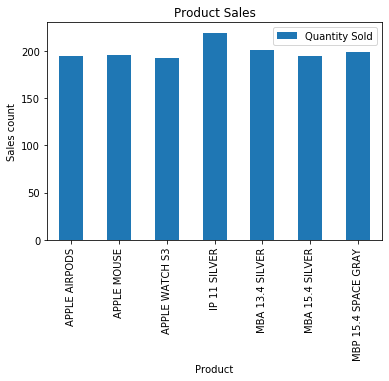

In [166]:
df_most_sold.plot(kind='bar')
plt.xlabel('Product')
plt.ylabel('Sales count')
plt.title('Product Sales')
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  """


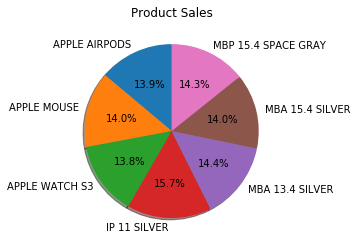

In [167]:
plt.pie(df_most_sold,
        labels=df_most_sold.index,
        startangle=90,
        shadow= True,
        autopct='%1.1f%%')
plt.title('Product Sales')
plt.show()

**Top 10 Customers**

In [168]:
df_var = df.groupby(['receiver.name']).size().reset_index()
df_var = df_var.nlargest(5, [0])

In [169]:
df_var = df_var.rename(columns = {'receiver.name':'Customer', 0 :'Purchased Items'})

In [170]:
df_var.set_index(['Customer'], inplace = True)
df_var

,Purchased Items
Customer,
James,48
Bob,35
Gurpreet,35
Alexander,34
Ahmad,33


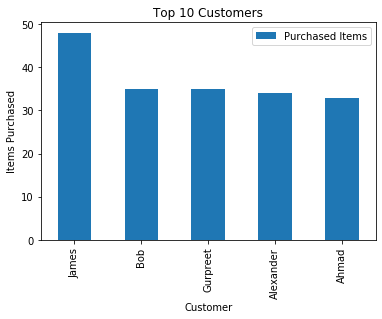

In [171]:
df_var.plot(kind='bar')
plt.xlabel('Customer')
plt.ylabel('Items Purchased')
plt.title('Top 10 Customers')
plt.show()

**Datetime formatting**

In [ ]:
c=pd.to_datetime((df['issuedAt']))
print(c)

In [192]:
df['createdDate']=c.dt.date
df['year']=c.dt.year
df['month']=c.dt.month
#column for name of day of week
df['Weekday'] =c.dt.day_name
#column for Week Number
df['Week_Number'] = c.dt.week

In [193]:
df.to_csv(r'/Users/jharnadohotia/Desktop/SFR AI ML/factura_edit.csv', index = False)

**- Sales Trend - Weekly (2019, 2020)**

In [ ]:
df_weekly = pd.DataFrame(df.groupby(['Week_Number','year']).sum()['amount'])

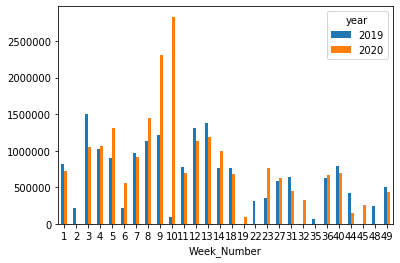

In [207]:
df_weekly.unstack()['amount'].plot.bar(rot=0)

**Sales trend - Monthly (2019, 2020)**

In [208]:
df_monthly = pd.DataFrame(df.groupby(['month','year']).sum()['amount'])

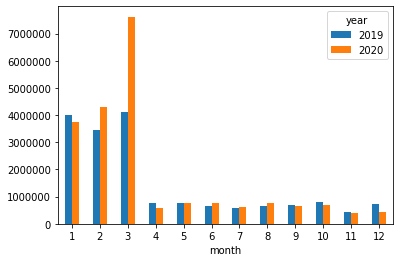

In [209]:
df_monthly.unstack()['amount'].plot.bar(rot=0)